NAME_1: Marco <br>
LAST-NAME_1: Introvigne<br>
STUDENT-ID_1: 10750466<br>
NAME_2: Antonio<br>
LAST-NAME_2: Urbano<br>
STUDENT-ID_2: 10527285<br>
NAME_3: Enrico<br>
LAST-NAME_3: Voltan<br>
STUDENT-ID_3: 10525467<br>
LEADERBOARD NICKNAME: 3LN (Three Little Neurons)<br>


This notebook is the one we used to train the models corresponding to the Roseau datasets. 




In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import shutil, random
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import cm
from tensorflow.keras.applications.vgg16 import preprocess_input 

SEED = 1234
tf.random.set_seed(SEED)
cwd = os.getcwd() 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parameters

In [ ]:
apply_data_augmentation = True
img_h = 832
img_w = 832
batch_size = 1

## Dataset


In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input 

In [ ]:
import math

def read_names(images_path):
    """ Find all the images from the images_path directory"""

    image_files = []

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)):
            image_files.append(dir_entry)

    return image_files

def read_rgb_mask(img_path, out_shape, crop_part, nrow, ncol):
    """ img_path: path to the mask file
    Returns the numpy array containing target values """

    mask_img = Image.open(img_path)
    mask_img = cropImg(mask_img, nrow, ncol)[crop_part]
    mask_img = mask_img.resize(out_shape, resample=Image.NEAREST)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr
    
def cropImg(im, rows, cols):
    """ Divide images by the number of columns and rows entered """
    # im = Image.open(infile)
    width = math.ceil(im.size[0]/cols)
    height = math.ceil(im.size[1]/rows)
    parts = []
    for i in range(rows):
        for j in range(cols):
            # print (i,j)
            box = (j*width, i*height, (j+1)*width, (i+1)*height)
            parts.append(im.crop(box))
    return parts

In [ ]:
class ParametricCustomDataset(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None,
               preprocessing_function=None, nrow=1, ncol=1, out_shape=(512,512)):
    
    subset_filenames = read_names(os.path.join(dataset_dir, "Images/img"))
        
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir    
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.nrow=nrow
    self.ncol=ncol
    self.out_shape = out_shape
    
  def on_epoch_end(self):
    """shuffle the file array after every epoch"""
    random.shuffle(array)

  def __len__(self):
    """adapt the lenght to the number of blocks"""
    return len(self.subset_filenames * self.nrow * self.ncol)

  def __getitem__(self, index):
    """image at (index % number of files) and select the block number (index / number of files) """
    curr_filename = self.subset_filenames[index%len(self.subset_filenames)]
    img = Image.open(os.path.join(self.dataset_dir,  'Images/img', curr_filename))
    x = index // len(self.subset_filenames)
    img = cropImg(img, self.nrow, self.ncol)[x]
    img = img.resize(self.out_shape) 
    img_arr = np.array(img)
  
    mask = read_rgb_mask(os.path.join(self.dataset_dir,  'Masks/img', curr_filename[:-4] + '.png'),
    self.out_shape, x, self.nrow, self.ncol)   

    mask_arr = np.array(mask)
    mask_arr = np.expand_dims(mask_arr, -1) 

    if "training" in self.which_subset and self.img_generator is not None and self.mask_generator is not None:

        img_t = self.img_generator.get_random_transform(img_arr.shape)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)

        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, img_t)
            
            curr_class_arr = np.uint8(curr_class_arr)
            
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
        #train only if the masks is composed of all the 3 classes
        if len(np.unique(out_mask)) < 3:
          return self.__getitem__((index + 1)%self.__len__())
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr.astype(float)/255, out_mask

In [ ]:
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=360,
                                      width_shift_range=0.4,
                                      height_shift_range=0.4,
                                      zoom_range=0.4,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=360,
                                       width_shift_range=0.4,
                                       height_shift_range=0.4,
                                       zoom_range=0.4,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:
path_tr = '/content/drive/MyDrive/Kaggle_2/Development_Dataset_Split/training/Roseau/Mais'
path_val = '/content/drive/MyDrive/Kaggle_2/Development_Dataset_Split/validation/Roseau/Mais'

dataset_train = ParametricCustomDataset(path_tr, 'training',
                                        img_generator=img_data_gen,
                                        mask_generator=mask_data_gen,
                                        nrow=1, ncol=2,
                                        preprocessing_function=preprocess_input,
                                        out_shape=(img_w,img_h))

dataset_valid = ParametricCustomDataset(path_val, 'validation',
                                        preprocessing_function=preprocess_input,
                                        nrow=1, ncol=2,
                                        out_shape=(img_w,img_h))

In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset_train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(batch_size)
valid_dataset = valid_dataset.repeat()

## Test Data Generator

In [ ]:
iterator = iter(train_dataset)

[0. 1. 2.]


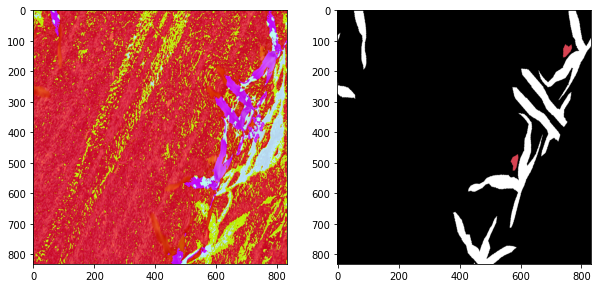

In [ ]:
%matplotlib inline
colors = []
colors.append([0, 0, 0]) # backgroun
colors.append([255, 255, 255] ) # crop
colors.append([216, 67, 82])  # weed

fig, ax = plt.subplots(1, 2, figsize=(10,10))

augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0])  # First element

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
target_img[np.where(target == 1)] = colors[1]
target_img[np.where(target == 2)] = colors[2]

ax[0].imshow(np.uint8(augmented_img * 255))
ax[1].imshow(np.uint8(target_img))

plt.show()

## UNET

In [ ]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()

for layer in vgg.layers:
  layer.trainable = True

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 832, 832, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 832, 832, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 832, 832, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 416, 416, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 416, 416, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 416, 416, 128)     147584    
______________________________________________________________

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    model.add(vgg)

    # Decoder
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=832, 
                     num_classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 26, 26, 512)       20024384  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 52, 52, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 52, 52, 832)       3834688   
_________________________________________________________________
re_lu (ReLU)                 (None, 52, 52, 832)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 104, 104, 832)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 104, 416)     3115424   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 104, 104, 416)     0

## Training

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def meanIoU(y_true, y_pred):
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3):
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

metrics = ['accuracy', meanIoU]

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
model.load_weights("/content/drive/MyDrive/Kaggle_2/MAIS_VGG.h5")

In [ ]:
callbacks=[]
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_meanIoU',  patience=20, restore_best_weights=True)
callbacks.append(es_callback)

In [ ]:
trained_model = model.fit(x=train_dataset,
                          epochs=10, 
                          steps_per_epoch=134,
                          validation_data=valid_dataset,
                          validation_steps=46, 
                          callbacks= [])

In [ ]:
model.save_weights("/content/drive/MyDrive/Kaggle_2/MAIS_VGG.h5")